In [1]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
from torchvision.datasets import Cityscapes, DatasetFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools
from tqdm import tqdm
import os
import cv2
import glob
import pickle
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
from PIL import Image
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights



if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

CITYSCAPES_DIR = '/work/cvcs2024/fiorottandi/workspace/data/cityscapes/'
GTA_DIR = '/work/cvcs2024/fiorottandi/workspace/data/gta/'
CHECKPOINT_DIR = '/work/cvcs2024/fiorottandi/workspace/checkpoints/'

IMAGE_SIZE_X = 1024
IMAGE_SIZE_Y = 1900
BATCH_SIZE = 4
NUM_WORKERS = 1


Using GPU


In [2]:
#Define transformations for input images
input_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for target images
target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_X, IMAGE_SIZE_Y)),
    transforms.ToTensor()
])


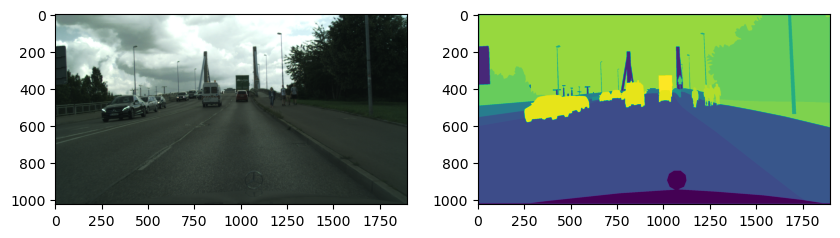

In [3]:
#Download cityscapes dataset and use transformations to resize the images to the right dimension
cityscapes = Cityscapes(CITYSCAPES_DIR, split='train', mode='fine', target_type='semantic', transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = cityscapes[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

cityscapes_loader = DataLoader(cityscapes, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

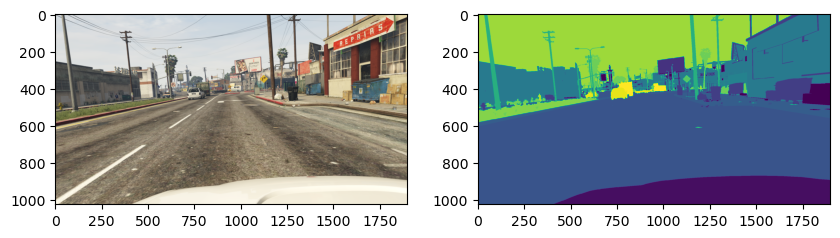

In [4]:
# GTADataset with resize transformations
class GTADataset(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super(GTADataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

gta = GTADataset(GTA_DIR, transform=input_transform, target_transform=target_transform)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))
plt.show()

gta_loader = DataLoader(gta, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/tmp/ipykernel_341587/3106160925.py:4: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)


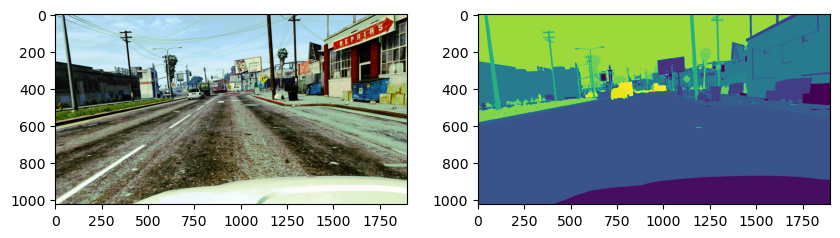

: 

In [5]:
# Define histogram matching function
def match_histogram(image, reference):
    """Match the histogram of the image to the reference image."""
    matched = exposure.match_histograms(np.array(image), np.array(reference), multichannel=True)
    return Image.fromarray(matched)

# Load a few Cityscapes images to use as reference for histogram matching, converting them to RGB
reference_images = [transforms.ToPILImage()(cityscapes[i][0].clone()).convert('RGB') for i in range(10)]

# Define a new GTA dataset class with histogram matching
class GTADatasetWithHistogramMatching(VisionDataset):
    def __init__(self, root, reference_images, transform=None, target_transform=None):
        super(GTADatasetWithHistogramMatching, self).__init__(root, transform=transform, target_transform=target_transform)
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.images = sorted(os.listdir(self.image_dir))
        self.labels = sorted(os.listdir(self.label_dir))
        assert len(self.images) == len(self.labels), "Mismatch between number of images and labels"
        self.reference_images = reference_images

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.labels[index])
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        # Apply histogram matching
        reference_image = self.reference_images[index % len(self.reference_images)]
        image = match_histogram(image, reference_image)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.images)

# Load GTA dataset with histogram matching
gta_histogram_matched = GTADatasetWithHistogramMatching(GTA_DIR, reference_images, transform=input_transform, target_transform=target_transform)

# Display a sample from GTA after histogram matching
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
img, target = gta_histogram_matched[4]
ax[0].imshow(img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1].imshow(target.permute(1, 2, 0))  
plt.show()

# DataLoader for GTA with histogram matching
gta_loader_histogram_matched = DataLoader(gta_histogram_matched, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


In [6]:
# Extract features using a pre-trained VGG16 model and find the closest pairs

# Load pre-trained VGG16 model
vgg = vgg16(pretrained=True).features.to(device).eval()

def extract_features(loader, model):
    """Extract features from the dataset using a pre-trained model."""
    features = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader):
            imgs = imgs.to(device)
            feats = model(imgs).view(imgs.size(0), -1)
            feats = F.normalize(feats, dim=1)
            features.append(feats.cpu())
    return torch.cat(features)

# Extract features for Cityscapes and GTA with histogram matching
cityscapes_features = extract_features(cityscapes_loader, vgg)
gta_features = extract_features(gta_loader_histogram_matched, vgg)



/homes/fmorandi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/homes/fmorandi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 16%|████████████████████▏                                                                                                          | 118/744 [07:20<38:39,  3.71s/it]

: 

: 

In [ ]:
# Compute cosine similarity and find the closest pairs
similarity_matrix = cosine_similarity(gta_features, cityscapes_features)
closest_pairs = similarity_matrix.argmax(axis=1)

# Create a dataset of the closest pairs
paired_dataset = [(gta_histogram_matched[i], cityscapes[closest_pairs[i]]) for i in range(len(gta_histogram_matched))]

# Plot histogram of cosine similarity scores
cosine_similarities = [similarity_matrix[i, closest_pairs[i]] for i in range(len(closest_pairs))]
plt.hist(cosine_similarities, bins=50, alpha=0.7, color='b')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity Scores for Paired Images')
plt.show()

# Plot a sample of the paired dataset
fix, ax = plt.subplots(2, 2, figsize=(10, 10))
sample_idx = 4
gta_img, gta_target = paired_dataset[sample_idx][0]
cityscapes_img, cityscapes_target = paired_dataset[sample_idx][1]
ax[0, 0].imshow(gta_img[0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[0, 1].imshow(gta_target.permute(1, 2, 0))
ax[1, 0].imshow(cityscapes_img[0].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
ax[1, 1].imshow(cityscapes_target.permute(1, 2, 0))
plt.show()

# Save the paired dataset to a file
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'wb') as f:
    pickle.dump(paired_dataset, f)

print('Paired dataset saved to /work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl')

In [ ]:
with open('/work/cvcs2024/fiorottandi/workspace/gta_to_cityscapes.pkl', 'rb') as f:
    gta_to_cityscapes = pickle.load(f)